# I. IMPORT REQUIRED LIBRARIES

In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np
import time
import pickle

# Plotation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import plotly.express as px

# Preprocessing Libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Model Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score,
    precision_score, recall_score, log_loss, precision_recall_curve, auc,
    classification_report
)

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss

# Hyperparameter Tuning
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    KFold, train_test_split, cross_val_score, StratifiedKFold,
    RandomizedSearchCV, GridSearchCV, HalvingRandomSearchCV
)
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Misc
from sklearn.metrics import make_scorer
from joblib import Parallel, delayed

# II. CREATING PIPELINE MODEL

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('train.csv')
train = train_data_org.copy()
train.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


In [ ]:
target_column = 'Response'
y = train[target_column]
X = train.drop(target_column, axis=1)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataPreprocessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scalers = {}
        self.policy_channel_mapping = None
        self.region_mapping = None
        self.upper_whisker = None

    def fit(self, X, y=None):
        # Xác định và lưu giới hạn trên cho 'Annual_Premium'
        Q1 = X['Annual_Premium'].quantile(0.25)
        Q3 = X['Annual_Premium'].quantile(0.75)
        IQR = Q3 - Q1
        self.upper_whisker = Q3 + 1.5 * IQR

        # Fit MinMaxScaler cho 'Annual_Premium' và 'Vintage'
        self.scalers['Annual_Premium'] = MinMaxScaler().fit(X[['Annual_Premium']])
        self.scalers['Vintage'] = MinMaxScaler().fit(X[['Vintage']])

        # Lưu các giá trị cho 'Policy_Sales_Channel' và 'Region_Code'
        policy_channel_counts = X['Policy_Sales_Channel'].value_counts()
        self.policy_channel_mapping = {k: 'Channel_A' if v > 100000 else 'Channel_B' if 74000 < v <= 100000 else 'Channel_C' if 10000 < v <= 74000 else 'Channel_D' for k, v in policy_channel_counts.items()}

        region_counts = X['Region_Code'].value_counts()
        self.region_mapping = {k: 'Region_A' if v >= 100000 else 'Region_B' if 11000 < v < 100000 else 'Region_C' for k, v in region_counts.items()}

        return self

    def transform(self, X, y=None):
        df = X.copy()

        # Xử lý ngoại lệ cho 'Annual_Premium'
        df['Annual_Premium'] = np.where(df['Annual_Premium'] > self.upper_whisker, self.upper_whisker, df['Annual_Premium'])

        # Chuyển đổi thuộc tính phân loại
        df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
        df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 1, '1-2 Year': 2, '> 2 Years': 3})
        df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})

        # Áp dụng MinMaxScaler
        for feature, scaler in self.scalers.items():
            df[feature] = scaler.transform(df[[feature]])

        # Chuyển đổi 'Age', 'Policy_Sales_Channel', và 'Region_Code'
        df['Age'] = df['Age'].apply(lambda x: 1 if x >= 20 and x <= 34 else 2 if x > 34 and x <= 61 else 3)
        df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].map(lambda x: self.policy_channel_mapping.get(x, 'Channel_D')).map({'Channel_A': 1, 'Channel_B': 2, 'Channel_C': 3, 'Channel_D': 4})
        df['Region_Code'] = df['Region_Code'].map(lambda x: self.region_mapping.get(x, 'Region_C')).map({'Region_A': 1, 'Region_B': 2, 'Region_C': 3})

        return df


In [ ]:
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, VotingClassifier

class SoftVotingClassifier(BaseEstimator):
    def __init__(self, random_state=42, dt_max_depth=None, lr_max_iter=100, bagging_n_estimators=50):
        """
        Khởi tạo SoftVotingClassifier với các thông số cụ thể cho mỗi bộ phân loại.

        Parameters:
        - random_state: Seed cho việc tái tạo kết quả.
        - dt_max_depth: Độ sâu tối đa của DecisionTreeClassifier.
        - lr_max_iter: Số lần lặp tối đa cho LogisticRegression.
        - bagging_n_estimators: Số lượng bộ phân loại trong BaggingClassifier.
        """
        self.random_state = random_state
        self.dt_max_depth = dt_max_depth
        self.lr_max_iter = lr_max_iter
        self.bagging_n_estimators = bagging_n_estimators
        self.voting_clf = None

    def fit(self, X_train, y_train):

        # Khởi tạo các estimator với các tham số đã cung cấp
        decision_tree = DecisionTreeClassifier(random_state=self.random_state, max_depth=self.dt_max_depth)
        logistic_regression = LogisticRegression(max_iter=self.lr_max_iter, random_state=self.random_state)
        bagging_classifier = BaggingClassifier(n_estimators=self.bagging_n_estimators, random_state=self.random_state)

        # Tạo VotingClassifier với voting mềm
        self.voting_clf = VotingClassifier(
            estimators=[('dt', decision_tree), ('lr', logistic_regression), ('bagging', bagging_classifier)],
            voting='soft'
        )

        # Huấn luyện VotingClassifier
        self.voting_clf.fit(X_train, y_train)

        return self

    def predict(self, X):
        """
        Dự đoán nhãn cho các mẫu trong X.

        Parameters:
        - X: Features để dự đoán.

        Returns:
        - Dự đoán nhãn cho mỗi mẫu.
        """
        if self.voting_clf is None:
            raise Exception("Model chưa được huấn luyện.")
        return self.voting_clf.predict(X)

    def predict_proba(self, X):
        """
        Dự đoán xác suất của các lớp cho mỗi mẫu trong X.

        Parameters:
        - X: Features để dự đoán xác suất.

        Returns:
        - Xác suất của các lớp cho mỗi mẫu.
        """
        if self.voting_clf is None:
            raise Exception("Model chưa được huấn luyện.")
        return self.voting_clf.predict_proba(X)


In [ ]:
import pandas as pd

class DataSelector:
    def __init__(self, selected_columns=None):
        if selected_columns is None:
            selected_columns = ['id', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium']
        self.selected_columns = selected_columns

    def select_columns(self, data):
        """Lấy ra các cột cụ thể từ DataFrame."""
        if data is not None:
            missing_cols = set(self.selected_columns) - set(data.columns)
            if missing_cols:
                raise ValueError(f"Missing columns in the input data: {missing_cols}")
            return data[self.selected_columns]
        else:
            raise ValueError("Input data is None.")

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
import time

class CatBoostModel:
    def __init__(self, iterations=500, learning_rate=0.05, l2_leaf_reg=3, early_stopping_rounds=10, verbose=100, random_state=42):
        self.model = CatBoostClassifier(iterations=iterations,
                                        learning_rate=learning_rate,
                                        l2_leaf_reg=l2_leaf_reg,
                                        early_stopping_rounds=early_stopping_rounds,
                                        verbose=verbose,
                                        random_state=random_state)

    def fit(self, X_train, y_train):
        start_time = time.time()
        self.model.fit(X_train, y_train)
        self.training_time = time.time() - start_time
        print(f"Training completed in {self.training_time:.2f} seconds.")

In [ ]:
from sklearn.base import BaseEstimator
from imblearn.pipeline import Pipeline as ImblearnPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer

class CustomModel(BaseEstimator):
    def __init__(self, data_preprocessor, soft_voting_classifier, catboost_model, data_selector):
        """
        Khởi tạo CustomModel với các component cụ thể.
        """
        self.data_preprocessor = data_preprocessor
        self.soft_voting_classifier = soft_voting_classifier
        self.catboost_model = catboost_model
        self.data_selector = data_selector
        self.ros = RandomOverSampler()

    def fit(self, X, y):
        # Xử lý dữ liệu ban đầu
        X_processed_origin = self.data_preprocessor.fit_transform(X)
        X_proccessed = X_processed_origin.copy()
        # Phân nhánh 1: Áp dụng RandomOverSampler và SoftVotingClassifier
        X_resampled, y_resampled = self.ros.fit_resample(X_processed, y)
        self.soft_voting_classifier.fit(X_resampled, y_resampled)
        X_proccessed = X_processed_origin.copy()
        # Phân nhánh 2: Áp dụng DataSelector và CatBoostModel
        X_selected = self.data_selector.select_columns(X_processed)
        self.catboost_model.fit(X_selected, y)

        return self

    def predict(self, X):
        raise NotImplementedError("CustomModel does not support a single predict method due to its branching nature.")


In [ ]:
CustomModel.fit(X, y)

TypeError: CustomModel.fit() missing 1 required positional argument: 'y'

# I. IMPORT REQUIRED LIBRARIES

In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np
import time
import pickle

# Plotation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import plotly.express as px

# Preprocessing Libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Model Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score,
    precision_score, recall_score, log_loss, precision_recall_curve, auc,
    classification_report
)

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss

# Hyperparameter Tuning
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    KFold, train_test_split, cross_val_score, StratifiedKFold,
    RandomizedSearchCV, GridSearchCV, HalvingRandomSearchCV
)
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Misc
from sklearn.metrics import make_scorer
from joblib import Parallel, delayed

# II. UPLOAD DATA

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('train.csv')
train = train_data_org.copy()
train.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [ ]:
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


# III. DATA PREPROCESSING

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataPreprocessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scalers = {}
        self.policy_channel_mapping = None
        self.region_mapping = None
        self.upper_whisker = None

    def fit(self, X, y=None):
        # Xác định và lưu giới hạn trên cho 'Annual_Premium'
        Q1 = X['Annual_Premium'].quantile(0.25)
        Q3 = X['Annual_Premium'].quantile(0.75)
        IQR = Q3 - Q1
        self.upper_whisker = Q3 + 1.5 * IQR

        # Fit MinMaxScaler cho 'Annual_Premium' và 'Vintage'
        self.scalers['Annual_Premium'] = MinMaxScaler().fit(X[['Annual_Premium']])
        self.scalers['Vintage'] = MinMaxScaler().fit(X[['Vintage']])

        # Lưu các giá trị cho 'Policy_Sales_Channel' và 'Region_Code'
        policy_channel_counts = X['Policy_Sales_Channel'].value_counts()
        self.policy_channel_mapping = {k: 'Channel_A' if v > 100000 else 'Channel_B' if 74000 < v <= 100000 else 'Channel_C' if 10000 < v <= 74000 else 'Channel_D' for k, v in policy_channel_counts.items()}

        region_counts = X['Region_Code'].value_counts()
        self.region_mapping = {k: 'Region_A' if v >= 100000 else 'Region_B' if 11000 < v < 100000 else 'Region_C' for k, v in region_counts.items()}

        return self

    def transform(self, X, y=None):
        df = X.copy()

        # Xử lý ngoại lệ cho 'Annual_Premium'
        df['Annual_Premium'] = np.where(df['Annual_Premium'] > self.upper_whisker, self.upper_whisker, df['Annual_Premium'])

        # Chuyển đổi thuộc tính phân loại
        df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
        df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 1, '1-2 Year': 2, '> 2 Years': 3})
        df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})

        # Áp dụng MinMaxScaler
        for feature, scaler in self.scalers.items():
            df[feature] = scaler.transform(df[[feature]])

        # Chuyển đổi 'Age', 'Policy_Sales_Channel', và 'Region_Code'
        df['Age'] = df['Age'].apply(lambda x: 1 if x >= 20 and x <= 34 else 2 if x > 34 and x <= 61 else 3)
        df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].map(lambda x: self.policy_channel_mapping.get(x, 'Channel_D')).map({'Channel_A': 1, 'Channel_B': 2, 'Channel_C': 3, 'Channel_D': 4})
        df['Region_Code'] = df['Region_Code'].map(lambda x: self.region_mapping.get(x, 'Region_C')).map({'Region_A': 1, 'Region_B': 2, 'Region_C': 3})

        return df


In [ ]:
# Bước 2: Khởi tạo và Fit DataPreprocessing
preprocessor = DataPreprocessing()
preprocessor.fit(train)

# Bước 3: Transform dữ liệu
train_full = preprocessor.transform(train)
train = train_full.copy()

# Hiển thị vài dòng đầu của dữ liệu đã được chuyển đổi
train.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,2,1,1,0,3,1,0.070366,2,0.716263,1
1,2,1,3,1,3,0,2,0,0.057496,2,0.598616,0
2,3,1,2,1,1,0,3,1,0.066347,2,0.058824,1
3,4,1,1,1,3,1,1,0,0.048348,1,0.667820,0
4,5,0,1,1,2,1,1,0,0.046259,1,0.100346,0
5,6,0,1,1,3,0,1,1,0.000000,3,0.574394,0
6,7,1,1,1,3,0,1,1,0.038578,1,0.826990,0
7,8,0,2,1,1,0,2,1,0.054696,2,0.214533,1
8,9,0,1,1,3,1,1,0,0.046488,1,0.062284,0
9,10,0,1,1,3,1,1,0,0.048631,1,0.242215,0


In [ ]:
import pickle

# Save the preprocessor to a file
with open('data_preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

In [ ]:
# Load the preprocessor from the file
with open('data_preprocessor.pkl', 'rb') as file:
    loaded_preprocessor = pickle.load(file)


# III. TRAIN TEST SPLIT RATIO

In [ ]:
target_column = 'Response'
y = train[target_column]
X = train.drop(target_column, axis=1)

## 3.1 RandomOverSampling

In [ ]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

# Train và kiểm tra mô hình trên dữ liệu đã xử lý
X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.1, random_state=42)

### 3.6.6 Voting Classifier

In [ ]:
# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_SoftVoting(X_train, y_train, X_valid, y_valid):
    start_time = time.time()

    decision_tree = DecisionTreeClassifier(random_state=42)
    logistic_regression = LogisticRegression(max_iter=100)
    bagging_classifier = BaggingClassifier(n_estimators=50, random_state=42)

    voting_clf = VotingClassifier(
        estimators=[('dt', decision_tree), ('lr', logistic_regression), ('bagging', bagging_classifier)],
        voting='soft'
    )
    voting_clf.fit(X_train, y_train)

    y_pred_proba = voting_clf.predict_proba(X_valid)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    logloss = log_loss(y_valid, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:, 1])
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Soft Voting')
    plt.legend(loc='lower right')
    plt.show()

    cm = confusion_matrix(y_valid, y_pred)

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using Soft Voting: %.3f' % accuracy)
    print('F1 Score using Soft Voting: %.3f' % f1)
    print('Log Loss using Soft Voting: %.3f' % logloss)
    print('AUC using Soft Voting: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    return voting_clf


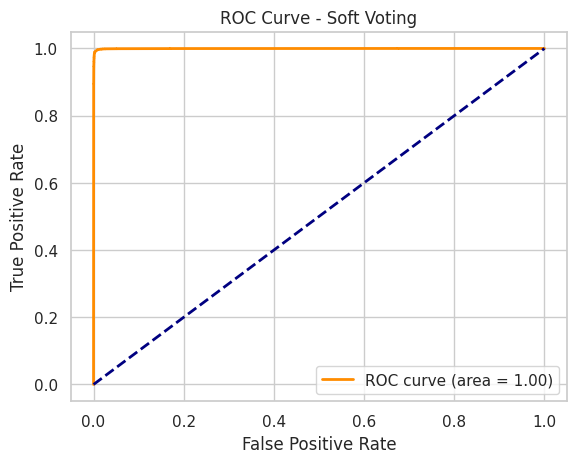

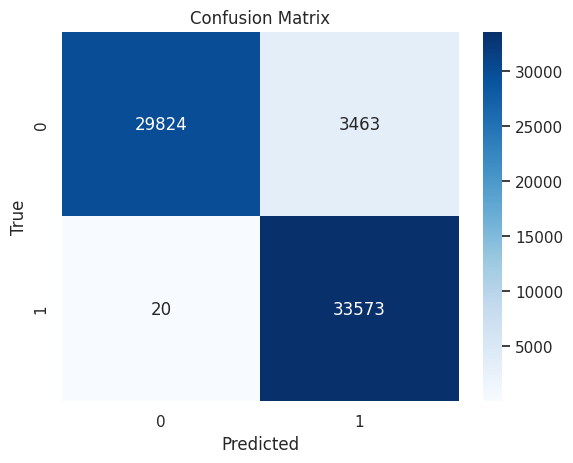

Accuracy using Soft Voting: 0.948
F1 Score using Soft Voting: 0.948
Log Loss using Soft Voting: 0.252
AUC using Soft Voting: 1.000
Thời gian thực thi: 00:03:49


In [ ]:
voting_clf = result_SoftVoting(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy)

In [ ]:
model_filename = 'trained_voting_classifier.pkl'

# Pickle the trained model
with open(model_filename, 'wb') as file:
    pickle.dump(voting_clf, file)

print(f"Model saved to {model_filename}")


Model saved to trained_voting_classifier.pkl


In [ ]:
# Load the pickled model
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
test_data_org = pd.read_csv('test.csv')
test = test_data_org.copy()

In [ ]:
# Now you can transform new data using the loaded preprocessor
test_transformed_org = loaded_preprocessor.transform(test)

In [ ]:
# Thực hiện dự đoán sử dụng mô hình đã tải
test_transformed = test_transformed_org.copy()
y_pred_new = loaded_model.predict(test_transformed)
# Hoặc để lấy xác suất dự đoán (nếu cần):
test_transformed = test_transformed_org.copy()
y_pred_proba_new = loaded_model.predict_proba(test_transformed)

In [ ]:
# Đảm bảo rằng dữ liệu test có cột 'id' để sử dụng làm cột định danh
if 'id' not in test.columns:
    print("Dữ liệu test phải có cột 'id'.")
else:
    # Thực hiện dự đoán sử dụng mô hình đã tải
    # Make sure to preprocess your test data as needed before predicting
    test_transformed = test_transformed.copy()
    y_pred_new = loaded_model.predict(test_transformed)

    # Hoặc để lấy xác suất dự đoán (nếu cần):
    # Getting the probability of the positive class (usually index 1 for binary classifiers)
    y_pred_proba_new = loaded_model.predict_proba(test_transformed)[:, 1]  # Select only the second column

    # Bước 4: Xuất kết quả dự đoán
    submission_df = pd.DataFrame({
        'id': test['id'],
        'Response': y_pred_new,
        'Response_Proba': y_pred_proba_new  # This is now 1-dimensional
    })

    # Lưu kết quả dự đoán vào file CSV
    submission_df.to_csv('submission_predictions.csv', index=False)

    print("Kết quả dự đoán đã được lưu vào 'submission_predictions.csv'.")


Kết quả dự đoán đã được lưu vào 'submission_predictions.csv'.


In [ ]:
test_data_org = pd.read_csv('submission_predictions.csv')
test = test_data_org.copy()
test['Response'].value_counts()

0    118374
1      8663
Name: Response, dtype: int64